## 3-1 내재 변동성 계산
옵션의 호가로부터 옵션의 내재변동성을 구하고 만기일과 행사가에 따른 그래프를 그려본다.(옵션 트레이더나 리스크관리자들의 매일 함)

In [2]:
from math import log, sqrt, exp
from scipy.stats import norm

In [3]:
def bsm_call_value(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    value = S0 * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)
    return value

In [4]:
def bsm_vega(S0, K, T, r, sigma):
    S0 = float(S0)
    d1 = (log(S0/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    value = S0 * norm.pdf(d1) * sqrt(T)
    return value

In [9]:
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it = 100):
    for i in range(it):
        sigma_est -= (bsm_call_value(S0, K, T, r, sigma_est)- C0)/bsm_vega(S0, K, T, r, sigma_est)
        if (i+1) % 10 == 0:
            print(i+1, sigma_est)
    return sigma_est

In [11]:
V0 = 17.6639 # 2014.03.31 VSTOXX 지수 종가
r = 0.01 # 무위험이자율

In [5]:
import os
os.getcwd()

'C:\\Users\\Jaehwan M\\Documents\\Python\\파생상품프로그래밍'

In [7]:
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

In [12]:
futures_data
## TTM은 잔존 만기(연 단위).

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,1396224000000000000,2014,4,17.85,1397779200000000000,0.049
497,1396224000000000000,2014,5,19.55,1400198400000000000,0.126
498,1396224000000000000,2014,6,19.95,1403222400000000000,0.222
499,1396224000000000000,2014,7,20.40,1405641600000000000,0.299
500,1396224000000000000,2014,8,20.70,1408060800000000000,0.375
501,1396224000000000000,2014,9,20.95,1411084800000000000,0.471
502,1396224000000000000,2014,10,21.05,1413504000000000000,0.548
503,1396224000000000000,2014,11,21.25,1416528000000000000,0.644


In [14]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null int64
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null int64
TTM          395 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 27.8+ KB


In [16]:
options_data['IMP_VOL'] = 0.0

In [19]:
tol = 0.5
for option in options_data.index:
    forward = futures_data[futures_data['M']]

Int64Index([46170, 46171, 46172, 46173, 46174, 46175, 46176, 46177, 46178,
            46179,
            ...
            46555, 46556, 46557, 46558, 46559, 46560, 46561, 46562, 46563,
            46564],
           dtype='int64', length=395)

In [22]:
options_data.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,IMP_VOL
46170,1396224000000000000,2014,4,C,1.0,16.85,1397779200000000000,0.049,0.0
46171,1396224000000000000,2014,4,C,2.0,15.85,1397779200000000000,0.049,0.0
46172,1396224000000000000,2014,4,C,3.0,14.85,1397779200000000000,0.049,0.0
46173,1396224000000000000,2014,4,C,4.0,13.85,1397779200000000000,0.049,0.0
46174,1396224000000000000,2014,4,C,5.0,12.85,1397779200000000000,0.049,0.0


In [23]:
options_data.loc[46170]

DATE         1396224000000000000
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     1397779200000000000
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

## Monte Carlo Simulation
금융공학뿐만 아니라 수치해석에서도 중요한 알고리즘. 옵션 가격 계산이나 위험관리 문제에서 유용하게 사용됨. 복잡도는 O(n)을 따름. 아주 쉬운 문제임에도 불구하고 계산량이 많고 메모리를 많이 요구하기 때문에 좀더 효율적으로 구현할 필요가 있다. 아래는 3가지 방법으로 유러피언 콜옵션의 가격을 계산하는 과정을 보여준다.

##### 순수 파이썬 구현

In [28]:
from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(20000)
t0 = time()

S0 = 100; K = 105; T = 1.0; r = 0.05; sigma =0.2
M = 50 # 시간구간 개수
dt = T/M # 하나의 시간 구간의 길이
I = 250000 # 샘플 경로의 수

# 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성.
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0,1)
            St = path[t-1] * exp((r - 0.5*sigma**2)*dt
                                + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)

# 몬테카를로 방법을 사용한 가격 추정
C0 = exp(-r*T) * sum(max(path[-1]-K,0) for path in S) / I

# 결과 출력
tpy = time() - t0
print("European Option Value: %.3f" % C0) 
print("Duration in Seconds: %7.3f" % tpy)

European Option Value: 7.999
Duration in Seconds:  40.214


In [29]:
sum_val = 0.0
for path in S:
    sum_val += max(path[-1]-K, 0)
C0 = exp(-r*T) * sum_val / I
round(C0,3)

7.999

##### Numpy를 이용한 벡터화

In [43]:
import numpy as np
from time import time

np.random.seed(20000)
t0 = time()

S0 = 100.; K = 105.; T = 1.; r = 0.05; sigma = 0.2
M = 50; dt = T/M; I = 250000

S = np.zeros((M+1, I))
S[0,:] = S0
for t in range(1,M+1):
    z = np.random.randn(I)
    S[t] = S[t-1] * np.exp((r-sigma**2/2)*dt + sigma*np.sqrt(dt)*z)
C0 = np.exp(-r*T) * sum(np.maximum(S[-1] - K, 0))/I

tnp1 = time() - t0
print("European Option Value: %.3f" % C0) 
print("Duration in Seconds: %7.3f" % tnp1)

European Option Value: 8.037
Duration in Seconds:   1.488


In [45]:
round(tpy/tnp1, 2)
#벡터화하면 30배 정도 빨라짐.

27.02

### Graphical Analysis

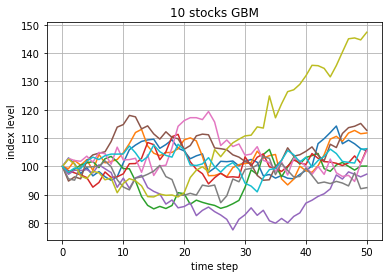

In [52]:
import matplotlib.pyplot as plt
plt.plot(S[:,:10]) # x축은 자연스럽게 0,1,2,...로
plt.grid(True)
plt.title("10 stocks GBM")
plt.xlabel("time step")
plt.ylabel("index level")
plt.show()

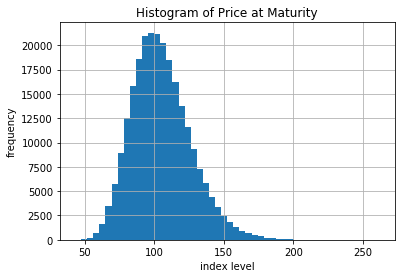

In [55]:
plt.hist(S[-1], bins =50)
plt.grid(True)
plt.title("Histogram of Price at Maturity")
plt.xlabel("index level")
plt.ylabel("frequency")
plt.show()

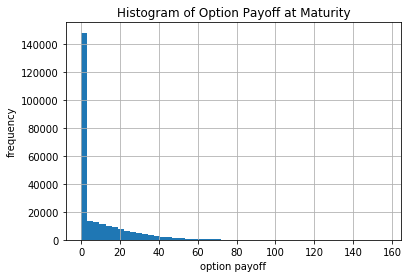

In [58]:
plt.hist(np.maximum(S[-1] - K, 0), bins =50)
plt.grid(True)
plt.title("Histogram of Option Payoff at Maturity")
plt.xlabel("option payoff")
plt.ylabel("frequency")
plt.show()

In [59]:
sum(S[-1] < K) # 내재가치 0인 시나리오 갯수.

133958

## Technical Analysis(기술적 분석)
기술적 분석이란 과거의 시장 정보(가격, 거래량)을 이용해 미래의 주가 방향을 예측하고자 하는 증권분석 방법론이다.

In [92]:
import numpy as np
import pandas as pd

In [93]:
raw = pd.read_csv('./source/tr_eikon_eod_data.csv',
                 index_col = 0, parse_dates = True)

In [94]:
AAPL = pd.DataFrame(raw['AAPL.O'])
AAPL.columns = ['Close']
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 1 columns):
Close    1972 non-null float64
dtypes: float64(1)
memory usage: 30.8 KB


Text(0.5,1,'Historical levels of the AAPL')

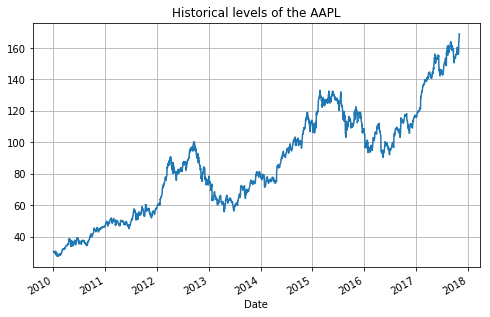

In [95]:
AAPL['Close'].plot(grid = True, figsize = (8, 5))
plt.title("Historical levels of the AAPL")

In [96]:
AAPL['42d'] = np.round(AAPL['Close'].rolling(window=42).mean(), 2)
AAPL['252d'] = np.round(AAPL['Close'].rolling(window=252).mean(), 2)

In [97]:
AAPL[:42] # 42번째에서부터 평균이 나오므로 
          # 41행부터 42d의 값이 결측값이 나오지 않음.

,Close,42d,252d
Date,,,
2010-01-04,30.572827,NaN,NaN
2010-01-05,30.625684,NaN,NaN
2010-01-06,30.138541,NaN,NaN
2010-01-07,30.082827,NaN,NaN
2010-01-08,30.282827,NaN,NaN
2010-01-11,30.015684,NaN,NaN
2010-01-12,29.674256,NaN,NaN
2010-01-13,30.092827,NaN,NaN
2010-01-14,29.918542,NaN,NaN


In [98]:
AAPL.tail()

,Close,42d,252d
Date,,,
2017-10-25,156.41,157.61,139.86
2017-10-26,157.41,157.51,140.03
2017-10-27,163.05,157.52,140.22
2017-10-30,166.72,157.60,140.43
2017-10-31,169.04,157.72,140.65


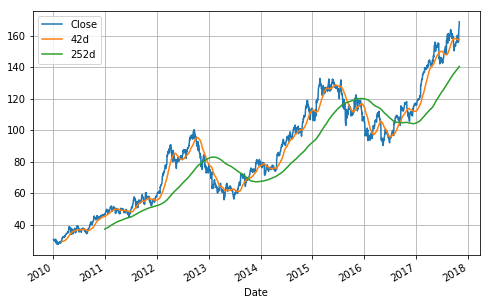

In [99]:
AAPL.plot(grid=True, figsize = (8,5))

##### 매수 신호
42일 추세가 252일 추세보다 SD(Signal Threshold)만큼 위에 도달했을 때
##### 대기 신호
42일 추세가 252일 추세의 위아래 SD 값 사이에 있을 때
##### 매도 신호
42일 추세가 252일 추세보다 SD 값만큼 아래에 도달했을 때

In [100]:
AAPL['42-252'] = AAPL['42d'] - AAPL['252d']
AAPL.tail()

,Close,42d,252d,42-252
Date,,,,
2017-10-25,156.41,157.61,139.86,17.75
2017-10-26,157.41,157.51,140.03,17.48
2017-10-27,163.05,157.52,140.22,17.30
2017-10-30,166.72,157.60,140.43,17.17
2017-10-31,169.04,157.72,140.65,17.07


In [101]:
AAPL.dropna(inplace = True)
AAPL.head()

,Close,42d,252d,42-252
Date,,,,
2010-12-31,46.079954,45.28,37.12,8.16
2011-01-03,47.081381,45.35,37.19,8.16
2011-01-04,47.327096,45.41,37.25,8.16
2011-01-05,47.714238,45.47,37.32,8.15
2011-01-06,47.675667,45.52,37.39,8.13


In [106]:
SD = 0.5 # Signal Threshold
AAPL['Position'] = np.where(AAPL['42-252'] > SD, 1, 0)
AAPL['Position'] = np.where(AAPL['42-252'] < -SD, -1, AAPL['Position'])
AAPL['Position'].value_counts()

 1    1260
-1     445
 0      16
Name: Position, dtype: int64

(-1.1, 1.1)

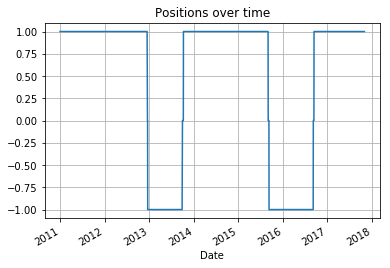

In [111]:
AAPL['Position'].plot(lw=1.5, grid = True)
plt.title("Positions over time")
plt.ylim([-1.1,1.1])

In [114]:
# 일간 로그수익률
AAPL['Market'] = np.log(AAPL['Close']/AAPL['Close'].shift(1)) 
# 오늘 번 돈 = 전일 포지션 * 수익률
AAPL['Strategy'] = AAPL['Position'].shift(1) * AAPL['Market'] 

이 전략은 전체적으로 시장 수익률을 상회한다.
이 결과는 실제 매매시 발생할 수 있는 다양한 이슈와 거래비용 같은
시장 미시구조 요소를 모두 무시하고 있다.
매매신호가 잦을수록 거래비용으로 인한 수익률 손실도 늘어난다.


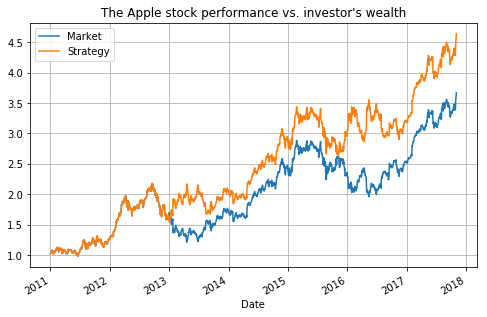

In [124]:
AAPL[['Market','Strategy']].cumsum().apply(np.exp).plot(grid = True,
                                                       figsize = (8,5))
plt.title("The Apple stock performance vs. investor's wealth")
print("이 전략은 전체적으로 시장 수익률을 상회한다.")
print("이 결과는 실제 매매시 발생할 수 있는 다양한 이슈와 거래비용 같은")
print("시장 미시구조 요소를 모두 무시하고 있다.")
print("매매신호가 잦을수록 거래비용으로 인한 수익률 손실도 늘어난다.")

### Tip: 금융 시계열 분석 : Pandas로!